In [1]:
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_formats = ['svg']
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 4, 3
plt.rcParams['grid.linestyle'] = 'dotted'

## Code

In [2]:
def pca(samples: np.ndarray, s: int = 2) -> tuple:
    mean = samples.mean(axis=0)
    samples_centered = samples - mean

    cov = np.cov(samples_centered.T)

    eigval, eigvec = np.linalg.eig(cov)

    ids = np.argsort(eigval)[::-1]
    eigval = eigval[ids]
    eigvec = eigvec[:, ids]
    
    print('explained variance ratio:', eigval[:s].sum() / eigval.sum())
    
    v = eigvec[:, :s]
    
    v *= v[0] / np.abs(v[0])
    
    a = samples_centered.dot(v)
    
    return mean, v, a

In [3]:
def ipca_step(samples: np.ndarray, w: np.ndarray, s: int) -> tuple:
    samples = samples.copy()
    
    mean = samples.mean(axis=0)
    samples_centered = samples - mean

    cov = np.cov(samples_centered.T)

    eigval, eigvec = np.linalg.eig(cov)

    ids = np.argsort(eigval)[::-1]
    eigval = eigval[ids]
    eigvec = eigvec[:, ids]
    
    evr = eigval[:s].sum() / eigval.sum()

    v = eigvec[:, :s]
    v *= v[0] / np.abs(v[0])
    
    a = samples_centered.dot(v)
    
    s2 = eigval[s:].mean()
    diag = np.diag((eigval[:s] - s2) / eigval[:s])

    new = mean + a.dot(diag).dot(v.T)
    samples = samples * w + new * (1 - w)
    
    return mean, v, a, samples, evr


def ipca(samples: np.ndarray, s: int = 2, niter: int = 250, th: float = 1e-5) -> tuple:
    missing = np.where(np.isnan(samples))
    
    if len(missing[0]) == 0:
        return pca(samples=samples, s=s)

    samples = samples.copy()
    
    w = np.ones(samples.shape)
    w[missing] = 0

    mean = np.nanmean(samples, axis=0)
    samples[missing] = mean[missing[1]]
    
    mean = None
    v = None
    a = None
    
    scores = []
    
    for _ in range(niter):
        mean_new, v_new, a_new, samples_new, evr = ipca_step(samples=samples, w=w, s=s)

        if a is not None:
            score = ((a_new - a) ** 2).sum() ** 0.5
            scores.append(score)
            
            if score < th:
                print('explained variance ratio:', evr)
                
                return mean_new, v_new, a_new
        
        mean = mean_new
        v = v_new
        a = a_new
        samples = samples_new
        
    print(f'warning! did not converge in {niter} iterations. best score: {min(scores)}')

    return mean_new, v_new, a_new

## EDA

In [4]:
prices = pd.read_csv('../data/2021_05_18/754А-C2-price.csv', encoding='cp1251', sep=';', index_col=0).T
places = pd.read_csv('../data/2021_05_18/754А-C2-place.csv', encoding='cp1251', sep=';', index_col=0).T

prices = prices.replace(0, np.nan)
places /= places.max().max()

for df in [prices, places]:
    df.index = pd.to_datetime(df.index)
    df.columns.name = None
    
    # df.drop(df[df.index > datetime(year=2021, month=4, day=29)].index, inplace=True)
    
assert (prices.index == places.index).all()

print('missing values rate:', np.isnan(places.values).sum() / places.values.size)

missing values rate: 0.022222222222222223


In [5]:
weekdays = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}

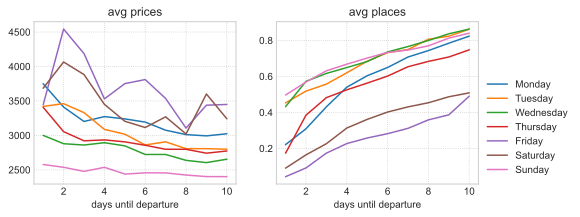

In [6]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 3)
dfs = [prices, places]
titles = ['avg prices', 'avg places']

for df, ax, title in zip(dfs, axes, titles):
    grp = df.groupby(lambda i: i.weekday()).mean().T
    grp = grp.rename(columns=weekdays)
    grp.plot(ax=ax, legend=False)
    ax.set_title(title)
    
    ax.set_xlabel('days until departure')
    
ax.legend(loc='lower left', bbox_to_anchor=(1, 0));

In [7]:
weekend = [5]

### Predicting missing values, using other features

### Places PCA (without missing values)

In [8]:
mask = ~places.isna().any(axis=1) & ~places.index.weekday.isin(weekend)
ids = places[mask].index

len(ids)

29

explained variance ratio: 0.942090150386286


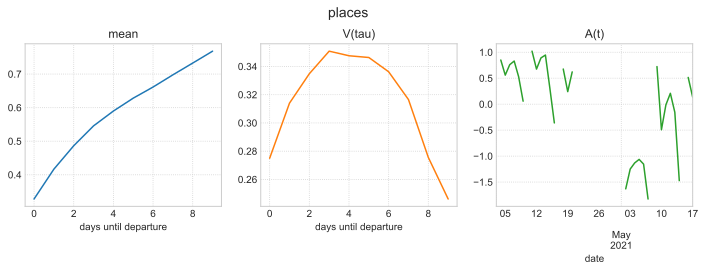

In [9]:
N_true = places[mask].values

mean, v, a = pca(N_true, s=1)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 3)

ax1.plot(mean, c='C0')
ax1.set_title('mean')
ax1.set_xlabel('days until departure')

ax2.plot(v.flatten(), c='C1')
ax2.set_title('V(tau)')
ax2.set_xlabel('days until departure')

pd.Series(a.flatten(), index=ids).reindex(places.index).plot(ax=ax3, c='C2')
ax3.set_title('A(t)')
ax3.set_xlabel('date');

fig.suptitle('places', fontsize=14, y=1.05);

In [10]:
N = mean + a.dot(v.T)

delta = N_true - N

delta.mean(), delta.std()

(1.6270509843644535e-18, 0.06746958641619857)

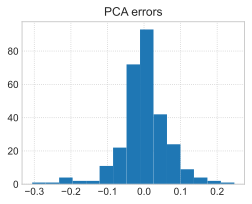

In [11]:
plt.hist(delta.flatten(), bins=15)
plt.title('PCA errors');

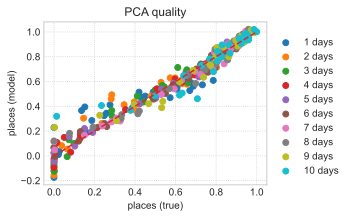

In [12]:
for i in range(N_true.shape[1]):
    plt.scatter(N_true[:, i], N[:, i], label=f'{i + 1} days')
    
ox = np.array([N_true.min(), N_true.max()])
plt.plot(ox, ox, ls='dashed', c='C3')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel('places (true)')
plt.ylabel('places (model)')
plt.title('PCA quality');

### Places IPCA (with missing values)

In [13]:
mask_ = ~places.index.weekday.isin(weekend)
ids_ = places[mask_].index

len(ids_)

38

explained variance ratio: 0.935240646481441


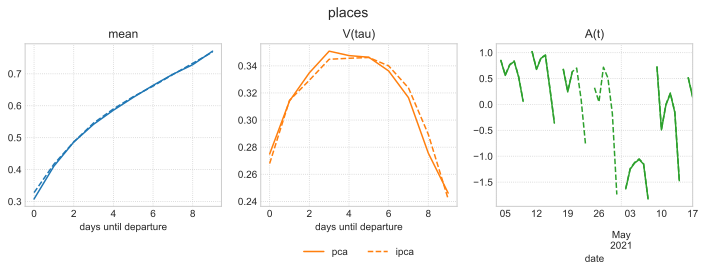

In [14]:
N_true_ = places[mask_].values

mean_, v_, a_,  = ipca(N_true_, s=1)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 3)

ax1.plot(mean_, c='C0')
ax1.plot(mean, c='C0', ls='dashed')
ax1.set_title('mean')
ax1.set_xlabel('days until departure')

ax2.plot(v.flatten(), c='C1', label='pca')
ax2.plot(v_.flatten(), c='C1', ls='dashed', label='ipca')
ax2.set_title('V(tau)')
ax2.set_xlabel('days until departure')

pd.Series(a.flatten(), index=ids).reindex(places.index).plot(ax=ax3, c='C2')
pd.Series(a_.flatten(), index=ids_).reindex(places.index).plot(ax=ax3, c='C2', ls='dashed')
ax3.set_title('A(t)')
ax3.set_xlabel('date');

fig.suptitle('places', fontsize=14, y=1.05)

ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2);

In [15]:
N_ = mean_ + a_.dot(v_.T)

delta_ = N_true_ - N_

np.nanmean(delta_), np.nanstd(delta_)

(5.51355533012462e-07, 0.07036995472953772)

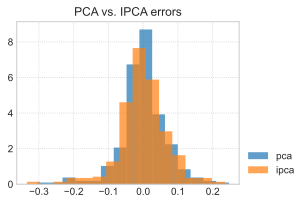

In [16]:
plt.hist(delta.flatten(), bins=15, density=True, alpha=0.7, label='pca')
plt.hist(delta_.flatten(), bins=15, density=True, alpha=0.7, label='ipca')
plt.title('PCA vs. IPCA errors')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0));

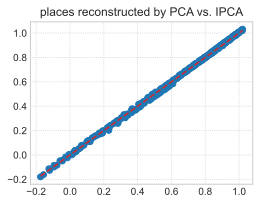

In [17]:
df1 = pd.DataFrame(N, index=ids).reindex(places.index)
df2 = pd.DataFrame(N_, index=ids_).reindex(places.index)

nmask = df1.notna().all(axis=1) & df2.notna().all(axis=1)
df1 = df1[mask]
df2 = df2[mask]

plt.scatter(df1.values.flatten(), df2.values.flatten())

xmin = df1.values.min()
xmax = df1.values.max()
plt.plot([xmin, xmax], [xmin, xmax], c='C3', ls='dashed')

plt.title('places reconstructed by PCA vs. IPCA');

## Price regression, using PCA values (without missing values)

In [18]:
C_true = prices[mask].values
C_true_flat = C_true.flatten()
N_flat = N.flatten()

cmask = ~np.isnan(C_true_flat) & ~np.isnan(N_flat)
C_true_flat = C_true_flat[cmask]
N_flat = N_flat[cmask]

assert C_true_flat.shape == N_flat.shape

b1 = np.cov(C_true_flat, N_flat)[0, 1] / N_flat.var()
b0 = C_true_flat.mean() - b1 * N_flat.mean()

b0, b1

(4140.785229500094, -1833.2306470438007)

In [19]:
C = b0 + b1 * N
C_flat = C.flatten()[cmask]

eps = C_true_flat - C_flat

R_C = 1 - eps.var() / C_true_flat.var()

eps.mean(), eps.std(), R_C

(-1.394115966221277e-13, 382.82820461998364, 0.6299209792660929)

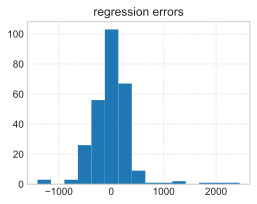

In [20]:
plt.hist(eps, bins=15)
plt.title('regression errors');

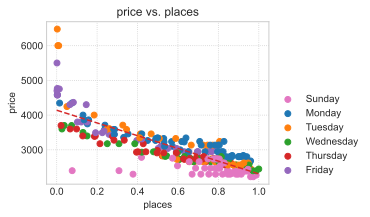

In [21]:
for i in range(N_true.shape[0]):
    weekday = ids[i].weekday()
    
    plt.scatter(N_true[i], C_true[i], color=f'C{weekday}', label=weekdays[weekday])
    
ox = np.array([N_true.min(), N_true.max()])
plt.plot(ox, b0 + b1 * ox, c='C3', ls='dashed')

handles, labels = plt.gca().get_legend_handles_labels()
legend = dict(zip(labels, handles))
handles = list(legend.values())
labels = list(legend.keys())

plt.legend(handles, labels, loc='lower left', bbox_to_anchor=(1, 0))

plt.xlabel('places')
plt.ylabel('price')
plt.title('price vs. places');

## Price regression, using IPCA values (with missing values)

In [22]:
C_true_ = prices[mask_].values
C_true_flat = C_true_.flatten()
N_flat = N_.flatten()

cmask_ = ~np.isnan(C_true_flat) & ~np.isnan(N_flat)
C_true_flat = C_true_flat[cmask_]
N_flat = N_flat[cmask_]

assert C_true_flat.shape == N_flat.shape

b1_ = np.cov(C_true_flat, N_flat)[0, 1] / N_flat.var()
b0_ = C_true_flat.mean() - b1_ * N_flat.mean()

b0, b1

(4140.785229500094, -1833.2306470438007)

In [23]:
C_ = b0_ + b1_ * N_
C_flat = C_.flatten()[cmask_]

eps_ = C_true_flat - C_flat

R_C = 1 - eps_.var() / C_true_flat.var()

eps_.mean(), eps_.std(), R_C

(1.0877242110540785e-13, 383.25207492792873, 0.6291144170208149)

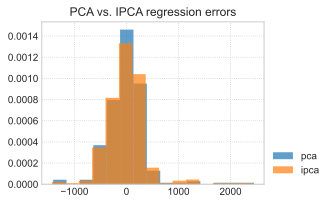

In [24]:
plt.hist(eps, bins=15, density=True, alpha=0.7, label='pca')
plt.hist(eps_, bins=15, density=True, alpha=0.7, label='ipca')
plt.title('PCA vs. IPCA regression errors')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0));

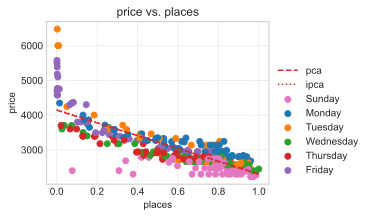

In [25]:
for i in range(N_true_.shape[0]):
    weekday = ids_[i].weekday()
    
    plt.scatter(N_true_[i], C_true_[i], color=f'C{weekday}', label=weekdays[weekday])
    
ox = np.array([np.nanmin(N_true_), np.nanmax(N_true_)])
plt.plot(ox, b0 + b1 * ox, c='C3', ls='dashed', label='pca')
plt.plot(ox, b0_ + b1_ * ox, c='C3', ls='dotted', label='ipca')

handles, labels = plt.gca().get_legend_handles_labels()
legend = dict(zip(labels, handles))
handles = list(legend.values())
labels = list(legend.keys())

plt.legend(handles, labels, loc='lower left', bbox_to_anchor=(1, 0))

plt.xlabel('places')
plt.ylabel('price')
plt.title('price vs. places');